In [1]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import pyxirr

class pct(float):
    def __str__(self):
        return '{:.4%}'.format(self)

In [2]:
### INPUT CELL ###

# READ TRANSACTIONS FROM CSV
input_data = pd.read_csv('./sample-portfolio.csv', sep=',', index_col='Date', parse_dates=True).sort_index()

acc_currency = 'USD'

In [3]:
# UTILITIES
start_date = input_data.index[0].date()
end_date = datetime.date.today()
timeline = pd.date_range(start=start_date, end=end_date)
years = timeline.shape[0]/365
day = datetime.timedelta(days=1)

sec_order = ['purchase', 'sale', 'split']
cash_order = ['deposit', 'withdrawal', 'dividend', 'reinvestment']

tickers = set(input_data.Ticker)
tickers.remove(acc_currency)
tickers = sorted(tickers)

In [4]:
# INITIAL ATTEMPT IN HANDLING SECURITIES WITH DIFFERENT CURRENCIES
def get_currency(ticker):
    print(ticker)
    return yf.Ticker(ticker).info['currency']

def get_currencies(tickers):
    currencies = set()
    currencies_full = list()
    for tick in tickers:
        currency = get_currency(tick).upper()
        if currency != acc_currency:
            if acc_currency == 'USD':
                currency += '=X'
            else:
                currency = acc_currency + currency + '=X'
            currencies.add(currency)
        currencies_full.append(currency)
    return currencies, currencies_full

def get_quotes(tickers, timeline):
    if len(tickers) != 0:
        df = yf.download(tickers, start=timeline[0].date() + day, end=timeline[-1].date() + day)['Close']
        df = df.reindex(index=timeline, method='nearest').fillna(method='ffill')
        return df

In [5]:
# INITIALISE DATAFRAMES
sec_trans = pd.DataFrame(0, columns=tickers, index = timeline)
splits = pd.DataFrame(1, columns=tickers, index = timeline)
ccys = pd.DataFrame(1, columns=tickers, index=timeline)
account = pd.DataFrame(0, columns=['ext_mov', 'inv_cap', 'int_mov', 'holding'], index = timeline)

In [6]:
# ORDER FUNCTIONS
def deposit(date, trans):
    account.ext_mov.at[date] = account.ext_mov.at[date] + trans.Quantity * trans.Price
    account.int_mov.at[date] = account.int_mov.at[date] + trans.Quantity * trans.Price - trans.Fee

def withdrawal(date, trans):
    account.ext_mov.at[date] = account.ext_mov.at[date] - trans.Quantity * trans.Price
    account.int_mov.at[date] = account.int_mov.at[date] - trans.Quantity * trans.Price - trans.Fee
    
def reinvestment(date, trans):
    account.int_mov.at[date] = account.int_mov.at[date] + trans.Quantity * trans.Price - trans.Fee

def purchase(date, trans):
    account.int_mov.at[date] = account.int_mov.at[date] - trans.Quantity * trans.Price / ccys.at[date, trans.Ticker]  - trans.Fee
    sec_trans.at[date, trans.Ticker] = sec_trans.at[date, trans.Ticker] + trans.Quantity

def sell(date, trans):
    print(ccys.at[date, trans.Ticker])
    account.int_mov.at[date] = account.int_mov.at[date] + trans.Quantity * trans.Price / ccys.at[date, trans.Ticker] - trans.Fee
    print(account.int_mov.at[date])
    sec_trans.at[date, trans.Ticker] = sec_trans.at[date, trans.Ticker] - trans.Quantity

def dividend(date, trans):
    account.int_mov.at[date] = account.int_mov.at[date] + trans.Quantity * trans.Price * ccys.at[date, trans.Ticker] - trans.Fee

def ssplit(date, trans):
    splits.at[date, trans.Ticker] = trans.Price

# TRANSACTION SORTING FUNCTION
def event(date, trans):
    if trans.Order == 'purchase':
        purchase(date, trans)
    elif trans.Order == 'sale':
        sell(date, trans)
    elif trans.Order == 'split':
        ssplit(date, trans)
    elif trans.Order == 'deposit':
        deposit(date, trans)
    elif trans.Order == 'withdrawal':
        withdrawal(date, trans)
    elif trans.Order == 'reinvestment':
        reinvestment(date, trans)
    elif trans.Order == 'dividend':
        dividend(date, trans)
    else:
        pass

def rev_cumprod(df):
    return df.iloc[::-1].cumprod().iloc[::-1]

def record_splits(tickers):
    for ticker in tickers:
        spls = yf.Ticker(ticker).splits.loc[start_date + day : end_date + day]
        for date, split in spls.iteritems():
            input_data.at[date] = [ticker, 'split', split, np.nan, 0]

def record_dividends(tickers):   
    for ticker in tickers:
        divs = yf.Ticker(ticker).dividends.loc[start_date + day : end_date + day]
        for date, div in divs.iteritems():
            input_data.at[date] = [ticker, 'dividend', div, holdings.at[date, ticker], 0]

In [7]:
# DOWNLOAD AND RECORD SPLITS DATA
record_splits(tickers)

# PROCESS SECURITY TRANSACTIONS
for date, transaction in input_data[input_data.Order.isin(sec_order)].iterrows():
    event(date, transaction)

# FILL HOLDINGS
splits = rev_cumprod(splits)
holdings = (sec_trans*splits).cumsum()

record_dividends(tickers)

# PROCESS CASH TRANSACTIONS
for date, transaction in input_data[input_data.Order.isin(cash_order)].iterrows():
    event(date, transaction)

# FILL EXTERNAL AND INTERNAL ACCOUNT MOVEMENTS
account.inv_cap = account.ext_mov.cumsum()
account.holding = account.int_mov.cumsum()

1
13368.0


In [8]:
market_values = get_quotes(tickers, timeline)

[*********************100%***********************]  3 of 3 completed


In [9]:
adj_market_values = market_values.multiply(ccys, axis=0)

In [10]:
# OUTPUT DATA
holdings_values = holdings.multiply(adj_market_values, axis=0)
holdings_values[acc_currency] = account.holding

portfolio = pd.DataFrame(0, columns=['Value'], index = timeline)
portfolio['Value'] = holdings_values.sum(axis=1)
portfolio['P/L'] = portfolio['Value'] - account.inv_cap
portfolio['%P/L'] = portfolio['P/L'] / account.inv_cap
portfolio['%day'] = (portfolio['Value'] - account.ext_mov).pct_change()
portfolio['Log Ret'] = np.log((portfolio['Value'] - account.ext_mov) / portfolio['Value'].shift(1))

cash_flows = - account.ext_mov
cash_flows.iloc[-1] = cash_flows.iloc[-1] + portfolio['Value'].iloc[-1]

asset_allocation = holdings_values.copy()
asset_allocation = asset_allocation.divide(portfolio['Value'], axis=0)

In [11]:
xirr = pyxirr.xirr(cash_flows.index, cash_flows.values)
xirr_ann = (1+xirr)**(1/years)-1
print('XIRR:', pct(xirr), '\nAnnualised XIRR', pct(xirr_ann))

XIRR: 40.3213% 
Annualised XIRR 20.5704%


<AxesSubplot:>

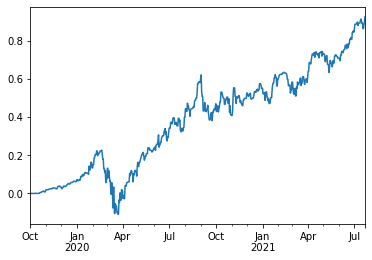

In [12]:
portfolio['%P/L'].plot()

<AxesSubplot:ylabel='2021-07-22 00:00:00'>

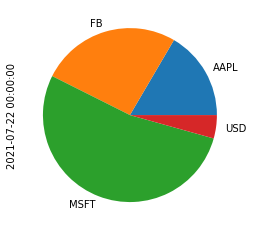

In [13]:
holdings_values.iloc[-1].plot.pie()